In [1]:
import scanpy as sc
import os
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.rcParams['pdf.fonttype']=42
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.figsize'] = (6, 6)

In [2]:
import tarfile
import pyarrow.csv as pv

In [7]:
file_list=['scATAC_matrix-M3a.tar.gz',
          'scATAC_matrix-M3b.tar.gz',
          'scATAC_matrix-M21a.tar.gz',
          'scATAC_matrix-M21b.tar.gz',]

In [8]:
read_options = pv.ReadOptions(block_size=1 * 1024 * 1024 * 1024, )
parse_options = pv.ParseOptions(delimiter='\t',)

In [10]:
df_list=[]
for file_path in tqdm(file_list):
    with tarfile.open(file_path, "r:gz") as tar:
        tsv_files = [f for f in tar.getnames() if f.endswith(".tsv")]
        tar.extract(tsv_files[0])
        table = pv.read_csv(tsv_files[0],
                            read_options=read_options,parse_options=parse_options)
        df=table.to_pandas()
        df=df.set_index(df.columns[-1])
        df_list.append(df)
        #os.remove(tsv_files[0])

100%|██████████| 4/4 [01:46<00:00, 26.58s/it]


In [13]:
[df.shape for df in df_list]

[(9627, 109629), (9425, 109629), (9017, 109629), (6725, 109629)]

In [11]:
from scipy.sparse import coo_matrix, csr_matrix

In [12]:
csr_list = [csr_matrix(df.astype(np.int32).values) for df in tqdm(df_list)]

100%|██████████| 4/4 [00:23<00:00,  5.89s/it]


In [15]:
expr_mat=pd.concat(
    df_list,
    axis=0
)
expr_mat.shape

(34794, 109629)

In [18]:
import anndata

In [20]:
# load sparse matrix:  create anndata object
adata = anndata.AnnData(X=csr_matrix(expr_mat))  # 数据矩阵 X 被转置为（obs x var）并转换为稀疏 CSR 格式
adata

AnnData object with n_obs × n_vars = 34794 × 109629

In [29]:
# load cell metadata:
cell_meta = pd.read_csv("meta_data-essential.tsv",sep='\t',index_col=0)
# load gene metadata:
gene_name = pd.read_csv("gene_name-peaks.tsv",sep='\t',index_col=0)
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['cell']
adata.var.index = gene_name['gene']

In [31]:
# load dimensional reduction:
lsi = pd.read_csv("reductions_lsi.tsv",sep='\t',index_col=0)
lsi.index = adata.obs.index
adata.obsm['lsi'] = lsi.to_numpy()
umap = pd.read_csv("reductions_umap.tsv",sep='\t',index_col=0)
umap.index = adata.obs.index
adata.obsm['umap'] = umap.to_numpy()

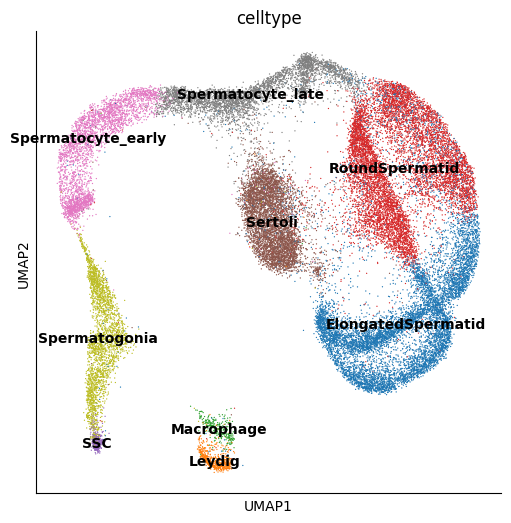

In [32]:
# plot a UMAP colored by sampleID to test:
sc.pl.embedding(adata,basis='umap', color=['celltype'],legend_loc='on data')

In [33]:
adata

AnnData object with n_obs × n_vars = 34794 × 109629
    obs: 'cell', 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'TSS.enrichment', 'celltype', 'group', 'UMAP_1', 'UMAP_2'
    uns: 'celltype_colors'
    obsm: 'lsi', 'umap'